# CV DL Pipeline (Training)

# Import Libraries

In [1]:
!pip install -q torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2 lightning==2.1.3 albumentations==1.4.0 timm==0.9.12

In [2]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import string
import pickle
import random
import joblib
import itertools
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.rcParams["figure.figsize"] = (12, 8)
from glob import glob
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, StratifiedGroupKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# os.system('pip install bitsandbytes')

import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.optim import Optimizer
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd.function import InplaceFunction
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import torchvision.models as models
from torch.distributions import Beta


# PyTorch Lightning imports:
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.tuner.tuning import Tuner
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping 
from pytorch_lightning.loggers import CSVLogger

from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup, get_cosine_with_hard_restarts_schedule_with_warmup

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
import cv2
import albumentations as A
import timm
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

# Pipeline

## Directory Settings

In [4]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
TRAIN_PATH = '/kaggle/input/hms-harmful-brain-activity-classification/'

## Data Loading

In [5]:
try:
    spectrograms;
    all_eegs;
except:
    spectrograms = np.load('/kaggle/input/brain-spectrograms/specs.npy',allow_pickle=True).item()
    all_eegs = np.load('/kaggle/input/unique-eeg-spectrograms-new/eeg_specs.npy',allow_pickle=True).item()

In [6]:
# ====================================================
# Data Loading
# ====================================================
df = pd.read_csv(TRAIN_PATH + 'train.csv')
TARGETS = df.columns[-6:]

print(f"train.shape: {df.shape}")
display(df.head())

train.shape: (106800, 15)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [7]:
train_df = df[df['label_id'].isin(all_eegs.keys())].copy().reset_index(drop=True)
train_df

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,2277392603,0,0.0,924234,0,0.0,1978807404,30539,GPD,0,0,5,0,1,5
2,722738444,0,0.0,999431,0,0.0,557980729,56885,LRDA,0,1,0,14,0,1
3,387987538,0,0.0,1084844,0,0.0,4099147263,4264,LRDA,0,0,0,3,0,0
4,2175806584,0,0.0,1219001,0,0.0,1963161945,23435,Seizure,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20178,3910994355,0,0.0,2146798838,0,0.0,4272062867,28488,LPD,0,9,0,2,0,7
20179,3938393892,0,0.0,2146798838,1,60.0,2587113091,28488,LPD,0,9,0,2,0,7
20180,1850739625,0,0.0,2146798838,3,162.0,2394534310,28488,LPD,0,9,0,2,0,7
20181,1306668185,0,0.0,2147312808,0,0.0,1216355904,57480,LPD,0,3,0,0,0,0


In [8]:
sum_votes = train_df[TARGETS].sum(axis=1) 
train_df['sum_votes'] = sum_votes.values.copy()
    
    
y_data = train_df[TARGETS].values
y_data = y_data / y_data.sum(axis=1, keepdims=True)
train_df[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train_df['target'] = tmp

train_df = train_df.reset_index()
print('Train non-overlapp eeg_id shape:', train_df.shape )
train_df

Train non-overlapp eeg_id shape: (20183, 18)


,index,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,sum_votes,target
0,0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,1.0,0.0000,0.000000,0.000000,0.000000,0.000000,3,NaN
1,1,2277392603,0,0.0,924234,0,0.0,1978807404,30539,GPD,0.0,0.0000,0.454545,0.000000,0.090909,0.454545,11,NaN
2,2,722738444,0,0.0,999431,0,0.0,557980729,56885,LRDA,0.0,0.0625,0.000000,0.875000,0.000000,0.062500,16,NaN
3,3,387987538,0,0.0,1084844,0,0.0,4099147263,4264,LRDA,0.0,0.0000,0.000000,1.000000,0.000000,0.000000,3,NaN
4,4,2175806584,0,0.0,1219001,0,0.0,1963161945,23435,Seizure,1.0,0.0000,0.000000,0.000000,0.000000,0.000000,3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20178,20178,3910994355,0,0.0,2146798838,0,0.0,4272062867,28488,LPD,0.0,0.5000,0.000000,0.111111,0.000000,0.388889,18,NaN
20179,20179,3938393892,0,0.0,2146798838,1,60.0,2587113091,28488,LPD,0.0,0.5000,0.000000,0.111111,0.000000,0.388889,18,NaN
20180,20180,1850739625,0,0.0,2146798838,3,162.0,2394534310,28488,LPD,0.0,0.5000,0.000000,0.111111,0.000000,0.388889,18,NaN
20181,20181,1306668185,0,0.0,2147312808,0,0.0,1216355904,57480,LPD,0.0,1.0000,0.000000,0.000000,0.000000,0.000000,3,NaN


## CFG

In [10]:
from albumentations.core.transforms_interface import ImageOnlyTransform

class TimeShift(ImageOnlyTransform):
    def __init__(self, shift_max, p=0.5):
        super(TimeShift, self).__init__(always_apply=False, p=p)
        self.shift_max = shift_max

    def apply(self, img, **params):
        # Calculate shift value as a fraction of the image width
        shift = np.random.uniform(-self.shift_max, self.shift_max)
        shift = int(shift * img.shape[1])  # img.shape should be (Height, Width, Channels)
        
        # Pad and shift the spectrogram
        if shift > 0:
            img = np.pad(img, ((0, 0), (shift, 0), (0, 0)), mode='constant')[:, :-shift, :]
        elif shift < 0:
            img = np.pad(img, ((0, 0), (0, -shift), (0, 0)), mode='constant')[:, -shift:, :]
        return img

    def get_transform_init_args_names(self):
        return ("shift_max",)

In [11]:
class CFG:
    competition = 'HMS'   # Competition Name
    seed = 42
########################################################################################################
    # Status
    train = True          # Train Mode
    debug = False         # Debug Mode 
########################################################################################################
    # Data
    img_size = [512, 512]
    batch_size = 32        
    valid_batch_size = batch_size
    num_workers = os.cpu_count()       # Threads in Data Loader
    target_cols = TARGETS
    in_channels = 3
    USE_KAGGLE_SPECTROGRAMS = True
    USE_EEG_SPECTROGRAMS = True
########################################################################################################
    # Training
    backbone = 'efficientnet_b4'
    pretrained = True
    weights = 'imagenet'
    epochs = 5
    gradient_checkpointing = False
    
    # To use it, add gradient_clip_val=CFG.max_grad_norm to the Trainer
    max_grad_norm = 10  # Prevent Gradient Explosion by Clipping Gradinet when exceeding this number
########################################################################################################
    # Optimizer
    encoder_lr = 0.0013         # Pretrained Model lr  
    decoder_lr = 1.5e-5         # Custom Model lr  
    
    #LLRD is a method that applies higher learning rates for top layers and lower learning rates for bottom layers
    #The goal is to modify the lower layers that encode more general information less than the top layers that are more specific to the pre-training task.
    layerwise_learning_rate_decay = 1.0  
    eps = 1e-6                # Adam Parameters 
    betas=(0.9, 0.999)        # Adam Parameters
    weight_decay = 0.015
    
    precision = "16-mixed"
    use_8bit_optimizer = False
    if use_8bit_optimizer:
        precision = '32'
    
    # Used for inital settings
    lr_finder = False
########################################################################################################
    # Scheduler
    use_scheduler = True    # Use Scheduler
    scheduler = 'cosine'      # 'cosine' or 'linear' or 'cosine_hard'
    num_cycles = 0.5
    num_warmup_steps = 1
    sch_interval = 'step'    # 'step' or 'epoch'
########################################################################################################
    # CV
    n_fold=5
    trn_fold=list(range(n_fold))
########################################################################################################
    # Augmentation
    mix_beta, mixup_prob = 1.0, 0.2
    params4mask = {
        "num_masks_x": (1, 3),
        "num_masks_y": (1, 3),    
        "mask_y_length": (5, 20),
        "mask_x_length": (5, 20),
        "fill_value": 0,
    }
    
    train_aug_list = [
        A.VerticalFlip(p=0.2),
        TimeShift(shift_max=0.1, p=0.3),
        A.XYMasking(**params4mask, p=0.3),
    ]
    
    valid_aug_list = [
    ]

In [12]:
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

## Utils

In [13]:
# ====================================================
# Utils
# ====================================================
def comp_metric(y_pred,y_test):
    y_pred = pd.DataFrame(y_pred.cpu().numpy())
    y_pred['id'] = np.arange(len(y_pred))

    y_test = pd.DataFrame(y_test.cpu().numpy())
    y_test['id'] = np.arange(len(y_test))

    return score(solution=y_test, submission=y_pred, row_id_column_name='id')

def get_score(y_preds, y_trues):
    score = comp_metric(y_preds, y_trues)
    return score

seed_everything(seed=CFG.seed)

42

In [14]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)
    return aug

## CV Split

In [16]:
train_1 = train_df[(train_df['sum_votes'] >= 3) & (train_df['sum_votes'] <= 20)].reset_index(drop=True)

In [17]:
# ====================================================
# CV split
# ====================================================
Fold = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True,random_state=5)
for n, (train_index, val_index) in enumerate(Fold.split(X=train_1, y=train_1['sum_votes'], groups=train_1.patient_id)):
    train_1.loc[val_index, 'fold'] = int(n)
train_1['fold'] = train_1['fold'].astype(int)
display(train_1.groupby('fold').size())

In [18]:
train_1.index = train_df[(train_df['sum_votes'] >= 3) & (train_df['sum_votes'] <= 20)].index
train_1.drop('index',axis=1,inplace=True)

In [19]:
train_2 = train_df[(train_df['sum_votes'] < 3) | (train_df['sum_votes'] > 20)]
train_2['fold'] = -1
train_df = pd.concat([train_1,train_2])
train_df.drop('index',axis=1,inplace=True)

In [20]:
train_df = train_df.sort_index()
train_df

In [21]:
train_df[['fold']].to_csv('cv.csv',index=False)

In [22]:
if CFG.debug:
    display(train_df.groupby('fold').size())
    train_df = train_df.sample(n=100, random_state=CFG.seed).reset_index(drop=True)
    display(train_df.groupby('fold').size())

## Dataset

In [23]:
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
TARS2 = {x: y for y, x in TARS.items()}

In [24]:
import numpy as np
import random

def hbac_cutmix_np(data, target, prob=0.5, cutmix_thr=0.75, margin=50, min_size=25, max_size=75, cut_eeg_spec=True):
    """
    Applies HBAC CutMix augmentation to numpy arrays with a specified probability.
    
    Parameters:
    - data: numpy array, batch of images.
    - target: numpy array, corresponding targets for the batch.
    - prob: float, probability of applying the augmentation.
    - cutmix_thr: float, threshold to consider samples for CutMix.
    - margin, min_size, max_size: int, parameters for the CutMix window.
    - cut_eeg_spec: bool, whether to apply CutMix to EEG spectrograms.
    
    Returns:
    - cutmix_data: numpy array, batch of augmented images.
    - target: numpy array, unmodified targets.
    """
    
    # Only proceed with augmentation with a certain probability
    if random.random() > prob:
        return data, target  # Return original data and target if not applying CutMix

    # CutMix Data
    cutmix_data = data.copy()

    for label_idx in range(target.shape[1]):
        indices = np.where(target[:, label_idx] >= cutmix_thr)[0]
        if len(indices) < 2:
            continue

        # Shuffle indices for CutMix
        shuffled_indices = np.random.permutation(len(indices))
        data_shuffled = data[indices][shuffled_indices]

        # Determine CutMix region
        start = random.randint(0, margin) if random.choice([True, False]) else random.randint(300-max_size-margin, 300-max_size)
        size = random.randint(min_size, max_size)

        # Apply CutMix to specified region
        for idx in indices:
            shuffled_idx = shuffled_indices[np.where(indices == idx)[0][0]]
            cutmix_data[idx, :, start:start+size, :] = data_shuffled[shuffled_idx, :, start:start+size, :]

            if cut_eeg_spec:
                # Adjust start for EEG spectrogram specifics
                start_eeg = 300 + 40 + start
                cutmix_data[idx, :, start_eeg:start_eeg+size, :] = data_shuffled[shuffled_idx, :, start_eeg:start_eeg+size, :]

    return cutmix_data, target


In [25]:
def mixup(image1, image2, label1, label2, alpha=1.0, mix_prob=0.5):
    """
    Apply mixup augmentation to a pair of images and labels with a given probability.
    
    Args:
    - image1, image2: Numpy arrays of the two images to mix.
    - label1, label2: The corresponding labels of the images.
    - alpha: Parameter for the Beta distribution.
    - k: Probability of applying the mixup.
    
    Returns:
    - The mixed or original images and labels based on the probability k.
    """
    if np.random.rand() > mix_prob:
        # If the random number is greater than k, return original images and labels
        return image1, label1 
    else:
        # Apply mixup
        lam = np.random.beta(alpha, alpha)
        mixed_image = lam * image1 + (1 - lam) * image2
        mixed_label = lam * label1 + (1 - lam) * label2
        return mixed_image, mixed_label

In [26]:
import random

def lower_upper_frequencies(spectrogram, p=0.5, damping_factor=0.5):
    """
    With a specified probability, lowers the amplitude of the upper half of the frequencies
    in the spectrogram by a damping factor.

    Parameters:
    - spectrogram: 2D numpy array representing the spectrogram.
    - probability: Probability with which to apply the damping.
    - damping_factor: Factor by which to reduce the amplitude of the upper frequencies.

    Returns:
    - Modified spectrogram.
    """
    if random.random() < p:
        # Calculate the index that splits the frequencies into upper and lower halves
        split_idx = spectrogram.shape[0] // 2
        
        # Dampen the upper frequencies
        spectrogram[:split_idx, :] *= damping_factor
    
    return spectrogram

In [30]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, cfg, data, train=True, transform=None, spectrograms=spectrograms, all_eegs=all_eegs, mixup=False):
        self.data  = data
        self.transforms = transform
        self.train = train
        self.cfg = cfg
        self.specs = spectrograms
        self.eeg_specs = all_eegs
        self.mixup = mixup
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.__getitems__([index])
    
    def __getitems__(self,indices):
        
        X, y = self._generate_data(indices)
        
        if self.transforms: 
            for i in range(X.shape[0]):
                X[i,] = self.transforms(image=X[i,])['image']
                
                        
                # Mixup
                if self.mixup:
                    j = random.randint(0, X.shape[0] - 1)
                    X[i,], y[i] = mixup(X[i,], X[j,], y[i], y[j], alpha=CFG.mix_beta, mix_prob=CFG.mixup_prob)
            
        
        if self.train:     ## Train
            return list(zip(X, y))
        
        else:            ## Test
            return X
        
        
    def _generate_data(self, indexes):
        X = np.zeros((len(indexes), 128, 256, 8),dtype='float32')
        y = np.zeros((len(indexes), 6),dtype='float32')
        img = np.ones((128, 256),dtype='float32')
        
        for j, i in enumerate(indexes):
            row = self.data.iloc[i]
            r = int(row['spectrogram_label_offset_seconds'] // 2)
            spec_id = row['spectrogram_id']

            for k in range(4):
                # EXTRACT 300 ROWS OF SPECTROGRAM
                img = self.specs[spec_id][r:r+300, k*100:(k+1)*100].T
                
                # LOG TRANSFORM SPECTROGRAM
                img = np.clip(img, np.exp(-6), np.exp(10))
                img = np.log(img)
                
                # STANDARDIZE PER IMAGE
                ep = 1e-6
                img = (img - 10) / (-6 + ep)
                total_mean = -0.17722809101175144
                img = np.nan_to_num(img, nan=total_mean)
                
                # CROP TO 256 TIME STEPS
                X[j, 14:-14, :, k] = img[:, 22:-22] / 2.0
        
            # EEG SPECTROGRAMS
            img = self.eeg_specs[row.label_id]
            X[j, :, :, 4:] = img
                
            if self.train:
                y[j,] = row[TARGETS]
            
        return X, y

## Show some samples

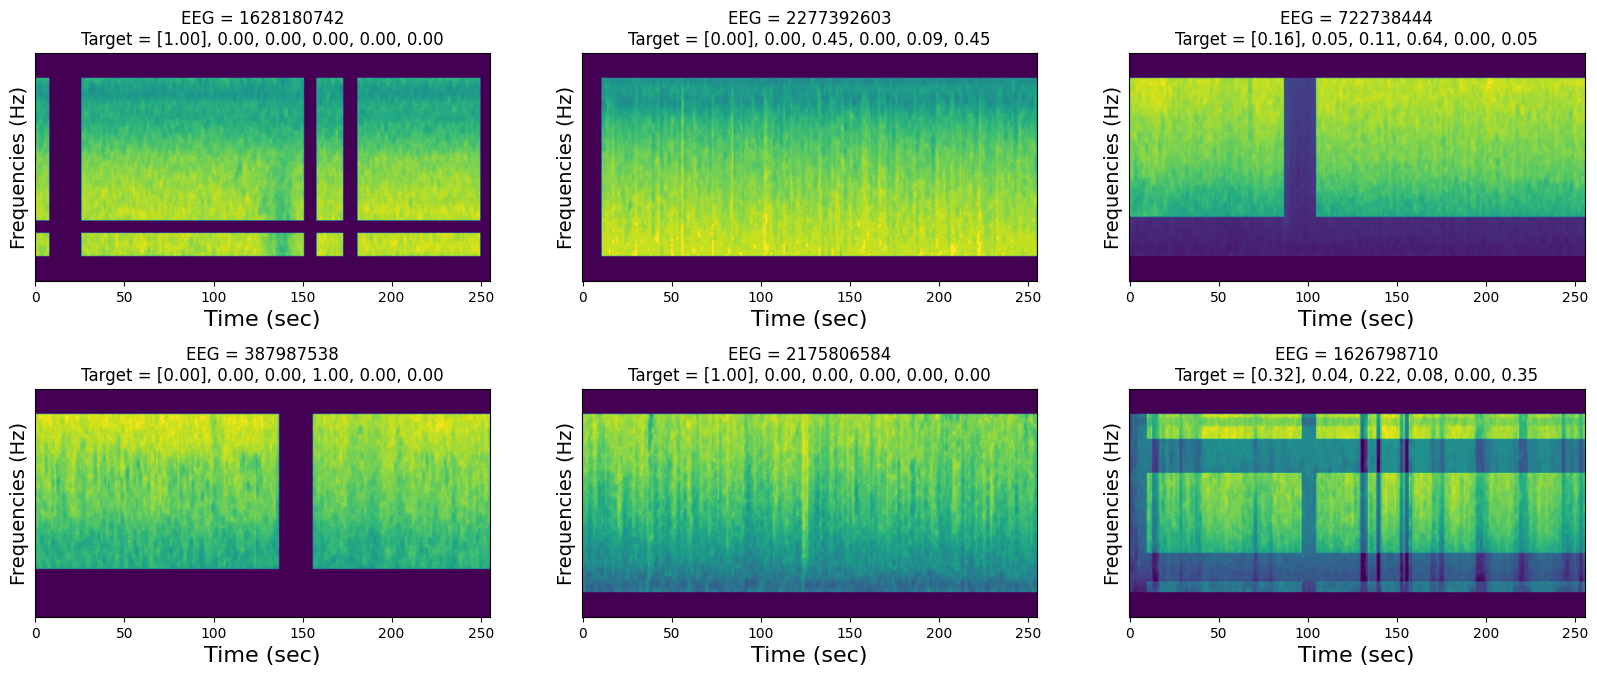

15454

In [31]:
dataset = TrainDataset(data=train_df,cfg=CFG,transform=get_transforms('train',cfg=CFG), mixup=True)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

ROWS = 2
COLS = 3
BATCHES = 1

for i, (x, y) in enumerate(dataloader):
    plt.figure(figsize=(20, 8))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS, COLS, j*COLS + k + 1)
            t = y[j*COLS + k]
            img = torch.flip(x[j*COLS+k, :, :, 0], (0,))
            mn = img.flatten().min()
            mx = img.flatten().max()
            img = (img-mn)/(mx-mn)
            plt.imshow(img)
            tars = f'[{t[0]:0.2f}]'
            for s in t[1:]:
                tars += f', {s:0.2f}'
            eeg = train_df.eeg_id.values[i*32+j*COLS+k]
            plt.title(f'EEG = {eeg}\nTarget = {tars}',size=12)
            plt.yticks([])
            plt.ylabel('Frequencies (Hz)',size=14)
            plt.xlabel('Time (sec)',size=16)
    plt.show()
    if i == BATCHES-1:
        break

del dataset, dataloader
gc.collect()

## Model

#### Get optimizer and scheduler

In [32]:
def get_optimizer_params(model, encoder_lr, decoder_lr, layerwise_learning_rate_decay, weight_decay=0.0):
        param_optimizer = list(model[0].named_parameters()) + list(model[1].named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
        ]
                
        return optimizer_parameters
    
    
def get_scheduler(cfg, optimizer, len_train_folds):
    num_train_steps = int(len_train_folds / cfg.batch_size * cfg.epochs)
    if cfg.scheduler == 'linear':
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
        )
    elif cfg.scheduler == 'cosine':
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
        )
    elif cfg.scheduler == 'cosine_hard':
        scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
        )
        
    return scheduler

#### The Model

In [33]:
def disable_dropout(model):
    for module in model.modules():
        if isinstance(module, torch.nn.Dropout):
            module.p = 0.0  # Set dropout probability to 0

In [34]:
# ====================================================
# Model
# ====================================================
class CustomModel(LightningModule):
    def __init__(self, cfg, criterion, train_folds, valid_folds, fold, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.criterion = criterion
        self.train_folds = train_folds
        self.valid_folds = valid_folds
        self.fold = fold
        self.pretrained = pretrained
        self.val_step_outputs = []
        self.val_step_labels = []
        if self.cfg.lr_finder:
            self.lr = CFG.encoder_lr

        # self.model = models.efficientnet_b0(pretrained=True)
        # self.model.classifier[1] = torch.nn.Linear(self.model.classifier[1].in_features, len(CFG.target_cols))
        
        # Create two separate ResNet34d backbones for each image
        self.backbone1 = timm.create_model('efficientnet_b0', pretrained=True, in_chans=1)
        self.backbone2 = timm.create_model('efficientnet_b0', pretrained=True, in_chans=4)
        
        # Disable dropout
        disable_dropout(self.backbone1)
        disable_dropout(self.backbone2)
        
        in_features = self.backbone1.num_features  # Combine features from both backbones
        self.fc = nn.Linear(in_features, len(CFG.target_cols))
                    
    def train_dataloader(self):
        train_dataset = TrainDataset(CFG, self.train_folds, transform=get_transforms('train', CFG), mixup=True)
        train_loader = DataLoader(train_dataset,
                                  batch_size=CFG.batch_size,
                                  shuffle=True,
                                  num_workers=CFG.num_workers,
                                  drop_last=True,
                                  pin_memory=True,
                                 )
        return train_loader
    
    
    def val_dataloader(self):
        valid_dataset = TrainDataset(CFG, self.valid_folds, transform=get_transforms('valid', CFG))
        valid_loader = DataLoader(valid_dataset,
                                  batch_size=CFG.valid_batch_size,
                                  shuffle=False,
                                  num_workers=CFG.num_workers,
                                  drop_last=False,
                                 )
        return valid_loader
    
    def training_step(self, batch, batch_idx):
        inputs, labels = batch[0], batch[1]
        
        y_preds = self(inputs)
        y_preds = F.log_softmax(y_preds, dim=1)
        loss = self.criterion(y_preds, labels)

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        for param_group in self.trainer.optimizers[0].param_groups:
            lr = param_group["lr"]
        self.log("lr", lr, on_step=True, on_epoch=False, prog_bar=True)

        return loss

    
    def validation_step(self, batch, batch_idx):
        inputs, labels = batch[0], batch[1]
        
        y_preds = self(inputs)
        y_preds = F.softmax(y_preds, dim=1)
        loss = self.criterion(y_preds, labels)

        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.val_step_outputs.append(y_preds)
        self.val_step_labels.append(labels)

        return loss

        
    def configure_optimizers(self):
        optimizer_parameters = get_optimizer_params([self.backbone1,self.backbone2],
                                                    encoder_lr=CFG.encoder_lr,
                                                    decoder_lr=CFG.decoder_lr,
                                                    layerwise_learning_rate_decay=CFG.layerwise_learning_rate_decay,
                                                    weight_decay=CFG.weight_decay)
        
        if self.cfg.use_8bit_optimizer:
            import bitsandbytes as bnb
            optimizer = bnb.optim.Adam8bit(optimizer_parameters,
                  lr=CFG.encoder_lr,
                  eps=CFG.eps,
                  betas=CFG.betas)
        else:
            optimizer = AdamW(optimizer_parameters,
                              lr=CFG.encoder_lr,
                              eps=CFG.eps,
                              betas=CFG.betas)
        
        scheduler = get_scheduler(CFG, optimizer, len(self.train_folds))
        lr_scheduler_dict = {"scheduler": scheduler, "interval": CFG.sch_interval}
        if self.cfg.use_scheduler:
            return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler_dict}
        else:
            return {'optimizer': optimizer}
    
    def on_validation_epoch_end(self):
        all_preds = torch.cat(self.val_step_outputs)
        all_labels = torch.cat(self.val_step_labels)
        self.val_step_outputs.clear()
        self.val_step_labels.clear()
        
        val_KLD = get_score(all_preds, all_labels)
        self.log("KLD_val", val_KLD, on_step=False, on_epoch=True, prog_bar=True)
        
        if self.trainer.global_rank == 0:
            print(f"\nEpoch: {self.current_epoch}, KLD_val: {val_KLD}", flush=True)
           
    
    # The Model Architicture
    def forward(self, x):
        
        x1 = [x[:, :, :, i:i+1] for i in range(4)]
        x1 = torch.concat(x1, dim=1)

        x2 = [x[:, :, :, i+4:i+5] for i in range(4)]
        x2 = torch.concat(x2, dim=3)

        x1 = x1.permute(0, 3, 1, 2)
        x2 = x2.permute(0, 3, 1, 2)
        
        
        # Pass each image through its respective backbone
        features1 = self.backbone1.forward_features(x1)
        features2 = self.backbone2.forward_features(x2)
        
        features1 = self.backbone1.forward_head(features1, pre_logits = True)
        features2 = self.backbone2.forward_head(features2, pre_logits = True)

        # Concatenate the features from both backbones
        combined_features = features1 * features2

        # Apply the final classification layer
        output = self.fc(combined_features)

        return output

## Training Loop

#### Training

In [36]:
# criterion = nn.KLDivLoss(reduction='batchmean')
criterion = nn.CrossEntropyLoss()
for fold in CFG.trn_fold:
    print(f"Fold: {fold}")
    train_folds = train_df.loc[train_df['fold'] != fold].loc[train_df['sum_votes'] >= 2].reset_index(drop=True)
    # train_folds = train_df.loc[train_df['fold'] != fold].reset_index(drop=True)
    valid_folds = train_df.loc[train_df['fold'] == fold].reset_index(drop=True)
    
    model = CustomModel(cfg=CFG,
                        criterion=criterion,
                        train_folds=train_folds,
                        valid_folds=valid_folds,
                        fold=fold,
                        pretrained=CFG.pretrained)

    checkpoint_callback = ModelCheckpoint(
        save_weights_only=True,
        monitor="KLD_val",
        dirpath=OUTPUT_DIR,
        mode="min",
        filename=f"model-f{fold}-loss={{val_loss:.4f}}-KLD_loss={{KLD_val:.4f}}",
        save_top_k=1,
        verbose=1,
    )


    trainer = Trainer(max_epochs=CFG.epochs,devices=1,gradient_clip_val=10,
                      accelerator='gpu',deterministic=False, 
                      precision=CFG.precision, strategy='auto',
                      callbacks=[checkpoint_callback],
                      logger=CSVLogger(save_dir=f'logs_f{fold}/'),)
    trainer.fit(model)
    
    del trainer, model, checkpoint_callback    

Fold: 0


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]


Epoch: 0, KLD_val: 1.1391006155873065


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 0, KLD_val: 0.7243581603780449


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 1, KLD_val: 0.6640802230533144


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 2, KLD_val: 0.545381580504413


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 3, KLD_val: 0.5204444125016143


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 4, KLD_val: 0.5080491181711254
Fold: 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]


Epoch: 0, KLD_val: 1.3847120693859714


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 0, KLD_val: 0.7088743944488737


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 1, KLD_val: 0.5941098821849989


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 2, KLD_val: 0.5158960106006062


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 3, KLD_val: 0.5003671945955371


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 4, KLD_val: 0.492254846559268
Fold: 2


Sanity Checking: |          | 0/? [00:00<?, ?it/s]


Epoch: 0, KLD_val: 1.4304924260876737


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 0, KLD_val: 0.6915311324187874


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 1, KLD_val: 0.594139502502208


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 2, KLD_val: 0.5317853280212984


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 3, KLD_val: 0.5222526013270138


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 4, KLD_val: 0.5167758517998701
Fold: 3


Sanity Checking: |          | 0/? [00:00<?, ?it/s]


Epoch: 0, KLD_val: 1.3472848788513136


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 0, KLD_val: 0.7652184874800466


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 1, KLD_val: 0.6413600990839061


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 2, KLD_val: 0.5868627091317323


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 3, KLD_val: 0.560170728459103


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 4, KLD_val: 0.5695210454874428
Fold: 4


Sanity Checking: |          | 0/? [00:00<?, ?it/s]


Epoch: 0, KLD_val: 1.295667662764708


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 0, KLD_val: 0.7958382030457015


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 1, KLD_val: 0.6042262686670729


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 2, KLD_val: 0.5702767500123259


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 3, KLD_val: 0.5366859855593371


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 4, KLD_val: 0.5326895439677005


# Check Validation Score

In [38]:
def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader), desc='Inference ')
    for step, images in tk0:
        images = images.to(device, dtype=torch.float) 
        with torch.no_grad():
            y_preds = model(images)
            y_preds = torch.softmax(y_preds, dim=1).cpu().numpy()
        preds.append(y_preds)
    return preds

In [39]:
predictions = []
for fold in CFG.trn_fold:
    print(f"Fold: {fold}")
    train_folds = train_df.loc[train_df['fold'] != fold].reset_index(drop=True)
    valid_folds = train_df.loc[train_df['fold'] == fold].reset_index(drop=True)
    # valid_folds = train_df.loc[train_df['fold'] == -1].loc[train_df['sum_votes'] == 1].reset_index(drop=True)


    model = CustomModel(cfg=CFG,
                        criterion=None,
                        train_folds=train_folds,
                        valid_folds=valid_folds,
                        fold=None,
                        pretrained=None)


    valid_dataset = TrainDataset(CFG, data=valid_folds, train=False, transform=get_transforms('valid', CFG))
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.valid_batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers,
                              drop_last=False)



    checkpoint_dir = f""
    checkpoint_paths = glob(f"{checkpoint_dir}model-f{fold}-*.ckpt")
    for checkpoint_path in tqdm(checkpoint_paths):
        print(checkpoint_path)
        model = CustomModel.load_from_checkpoint(checkpoint_path, map_location=device,cfg=CFG, criterion=None, train_folds=None, valid_folds=None, fold=None)
        prediction = inference_fn(valid_loader, model, device)
        prediction = np.concatenate(prediction)
        predictions.append(prediction)
        del model, prediction; gc.collect()
        torch.cuda.empty_cache()
    
    del valid_loader

Fold: 0


  0%|          | 0/1 [00:00<?, ?it/s]

model-f0-loss=val_loss=1.4668-KLD_loss=KLD_val=0.5080.ckpt


Inference :   0%|          | 0/101 [00:00<?, ?it/s]

Fold: 1


  0%|          | 0/1 [00:00<?, ?it/s]

model-f1-loss=val_loss=1.4780-KLD_loss=KLD_val=0.4923.ckpt


Inference :   0%|          | 0/102 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/1 [00:00<?, ?it/s]

model-f2-loss=val_loss=1.4446-KLD_loss=KLD_val=0.5168.ckpt


Inference :   0%|          | 0/77 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/1 [00:00<?, ?it/s]

model-f3-loss=val_loss=1.4795-KLD_loss=KLD_val=0.5602.ckpt


Inference :   0%|          | 0/84 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/1 [00:00<?, ?it/s]

model-f4-loss=val_loss=1.4813-KLD_loss=KLD_val=0.5327.ckpt


Inference :   0%|          | 0/94 [00:00<?, ?it/s]

In [41]:
idx = list(train_df[train_df['fold'] == 0].index)
for f in [1,2,3,4]:
     idx += list(train_df[train_df['fold'] == f].index)
y_preds = pd.DataFrame(np.concatenate(predictions),index=idx).reset_index(drop=True).values
y_true = train_df.loc[idx,TARGETS].values

In [42]:
def _comp_metric(y_pred,y_test):
    y_pred = pd.DataFrame(y_pred)
    y_pred['id'] = np.arange(len(y_pred))

    y_test = pd.DataFrame(y_test)
    y_test['id'] = np.arange(len(y_test))

    return score(solution=y_test, submission=y_pred, row_id_column_name='id')

_comp_metric(y_preds,y_true)

# 0.6302195999689458

# 0.6240329360037372

# 0.6006151305819116

# 0.5796454544888501

# 0.5790848363641213

# with 6 and -4
# 0.5790313634762209

# with training on 3-20 votes only
# 0.5651997692486851

# Drop samples with 1 votes
# 0.5502737753667538

# Use better scaling
# 0.5424511232571227

# New eeg?
# 0.5407424121684358

# Multiplying features
# 0.5393073615225246

# Add mixup alpha=1.0, p=0.25
# 0.5329731145107823

# Adding Cody aug + drop horizontal flip
# 0.5248020289166526

# Disabling Dropout
# 0.5230933401809205

0.5206593019794447